In [1]:
from tools import HopfieldNetwork
import numpy as np

# 3.5 Capacity

## 3.5.1 Capacity Stress Testing

### How many patterns could safely be stored? Was the drop in performance gradual or abrupt?

Abrupt 100% drop in performance once p4 was added.

In [2]:
distorted_pixels = 100

for i in range(1, 10): 
    hn = HopfieldNetwork(1024)
    pattern_indices = [x for x in range(1, i+1)]
    hn.fit(pattern_indices=pattern_indices)

    distorted_memories = hn.distort_patterns(
        num_units=distorted_pixels,
        pattern_indices=pattern_indices
    )

    patterns_pred = hn.recall(inputs=distorted_memories)
    results = hn.evaluate(
        patterns_pred=patterns_pred,
        pattern_indices=pattern_indices
    )
    print(results)


[True]
[True, True]
[True, True, True]
[False, False, False, False]
[False, False, False, False, False]
[False, False, False, False, False, False]
[False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False]


### Try to repeat this with learning a few random patterns instead of the pictures and see if you can store more.

The Hopfield network is able to store more random patterns.

In [3]:
from tools import generate_random_patterns

distorted_pixels = 100

for i in range(1, 10): 
    hn = HopfieldNetwork(1024)
    pattern_indices = [x for x in range(1, i+1)]
    random_patterns = generate_random_patterns(i)

    hn.fit(patterns=random_patterns)

    distorted_memories = hn.distort_patterns(
        num_units=distorted_pixels,
        patterns=random_patterns
    )

    random_patterns_pred = hn.recall(inputs=distorted_memories)
    results = hn.evaluate(
        patterns_pred=random_patterns_pred,
        patterns=random_patterns
    )
    print(results)


[True]
[True, True]
[True, True, True]
[True, True, True, True]
[True, True, True, True, True]
[True, True, True, True, True, True]
[True, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True, True]


### It has been shown that the capacity of a Hopfield network is around 0.138N. How do you explain the difference between random patterns and the pictures?

The Hopfield network is able to store more random patterns because random patterns are less correlated, whereas pictures tend to have more correlated features.

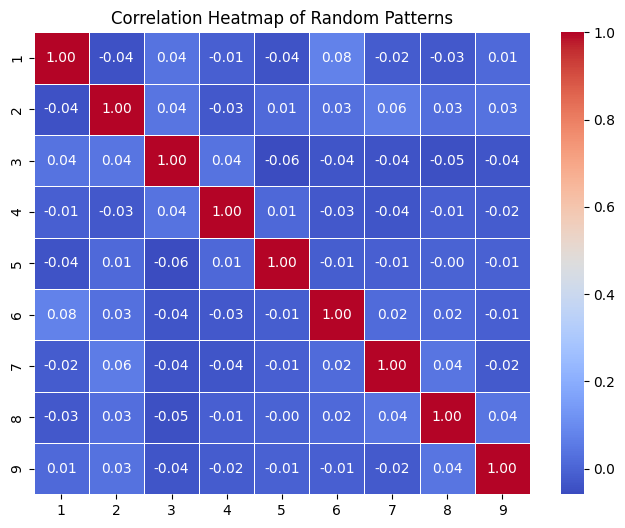

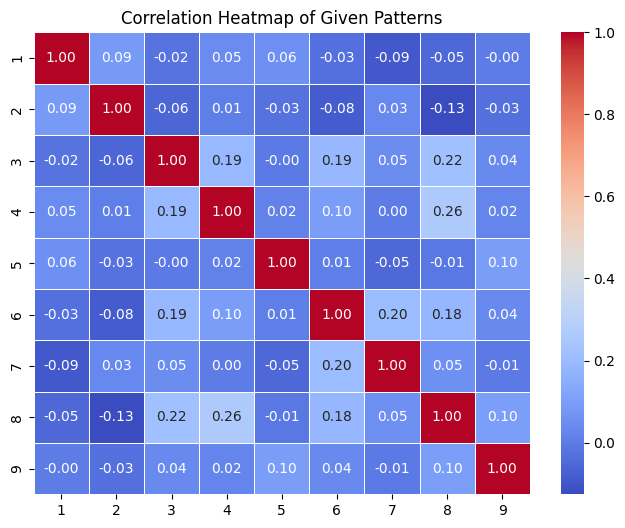

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

random_patterns_correlation = pd.DataFrame(random_patterns.T).corr()
patterns_correlation = pd.DataFrame(hn._load_pattern(None, [x for x in range(1,10)]).T).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(random_patterns_correlation, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", xticklabels=range(1, 10), yticklabels=range(1, 10))
plt.title('Correlation Heatmap of Random Patterns')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(patterns_correlation, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", xticklabels=range(1, 10), yticklabels=range(1, 10))
plt.title('Correlation Heatmap of Given Patterns')
plt.show()

## 3.5.2 Stability Testing

### What happens with the number of stable patterns as more are learned?

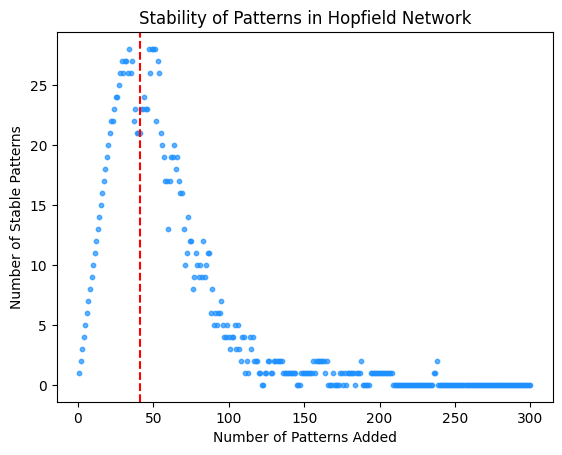

In [44]:
num_patterns=300
network_size=300
random_patterns = generate_random_patterns(num_patterns=num_patterns, pattern_size=network_size)
hn = HopfieldNetwork(n_nodes=network_size)
stable_counts = hn.fit_incremental(random_patterns)
capacity = 0.138 * network_size

plt.scatter(range(1, num_patterns + 1), stable_counts, s=10, alpha=0.7, c='dodgerblue')
# plt.plot(range(1, num_patterns + 1), stable_counts)
plt.axvline(x=capacity, color='red', linestyle='--', label=f'Capacity = {capacity}')

plt.xlabel("Number of Patterns Added")
plt.ylabel("Number of Stable Patterns")
plt.title("Stability of Patterns in Hopfield Network")

plt.show()

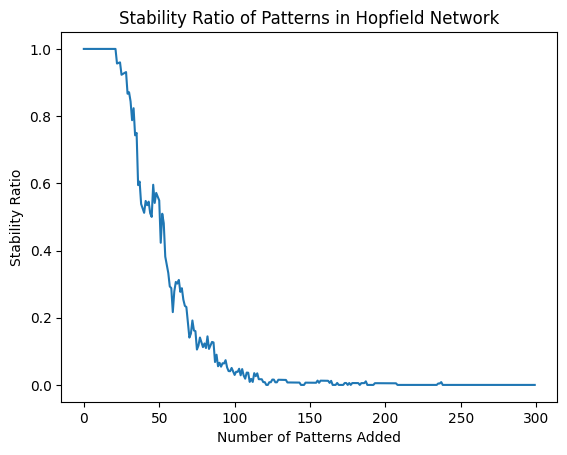

In [39]:
def divide_lists_elementwise(list1, list2):
    result = [a / b for a, b in zip(list1, list2)]
    return result

ratio = divide_lists_elementwise(stable_counts, range(1, num_patterns + 1))

plt.plot(ratio)

plt.xlabel("Number of Patterns Added")
plt.ylabel("Stability Ratio")
plt.title("Stability Ratio of Patterns in Hopfield Network")

plt.show()

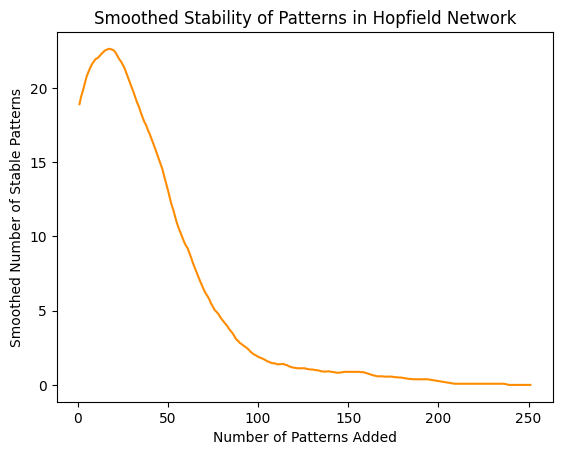

In [45]:
window_size = 50
smoothed_counts = np.convolve(stable_counts, np.ones(window_size)/window_size, mode='valid')

plt.plot(range(1, len(smoothed_counts) + 1), smoothed_counts, color='darkorange')
plt.xlabel("Number of Patterns Added")
plt.ylabel("Smoothed Number of Stable Patterns")
plt.title("Smoothed Stability of Patterns in Hopfield Network")
plt.show()

### Header 3

### Header 3

### Header 3

### Header 3